In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import sys
import numpy as np

This notebook is first fills the missing values with interpolation then conducts some analysis for feature engineering 

In [2]:
def load_data(filepath):
    """
    Loads the plant forecast data from a CSV file.
    """
    try:
        # Read CSV file. Adjust `parse_dates` if necessary depending on your columns.
        df = pd.read_csv(filepath, parse_dates=['effectivedate'])
        return df
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        sys.exit(1)

In [3]:
data=load_data("final_data.csv")

In [4]:
data.head()

,effectivedate,forecast_provider,plant_name,fc0,fc1200,fc40,fc55,fc60,fc75,production,...,sunshine_duration,precipitation_sum,rain_sum,showers_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum
0,2022-01-01 00:00:00,Provider 1,Plant A,5.498515,8.245363,2.456326,2.932484,2.932484,2.371797,11.886,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
1,2022-01-01 00:00:00,Provider 2,Plant A,5.040864,8.276702,7.520027,7.263067,7.088938,6.841885,11.886,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
2,2022-01-01 00:00:00,Provider 5,Plant A,5.498520,8.245360,2.456330,2.932480,2.932480,2.371800,11.886,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
3,2022-01-01 01:00:00,Provider 1,Plant A,9.926987,6.013426,5.336242,3.760841,3.760841,2.797678,9.897,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58
4,2022-01-01 01:00:00,Provider 2,Plant A,9.561205,6.252626,8.984542,7.975365,7.543575,6.340461,9.897,...,30312.5,0.0,0.0,0.0,0.0,0.0,9.7,25.9,38.0,8.58


In [5]:
def find_missing_hours(data, plants, providers):
    """
    Finds missing hours within the range of `effectivedate` for each plant and provider.

    Args:
        data (pd.DataFrame): The plant forecast DataFrame.
        plants (list): List of plants to include in the analysis.
        providers (list): List of providers to check.

    Returns:
        dict: A dictionary where keys are plant names, and values are DataFrames of missing hours for each provider.
    """
    # Filter data for the specified plants and providers
    filtered_data = data[
        (data['plant_name'].isin(plants)) & (data['forecast_provider'].isin(providers))
    ]

    # Extract hour from the datetime column
    filtered_data['hour'] = filtered_data['effectivedate'].dt.floor('h')

    # Initialize result dictionary
    missing_hours = {}

    # Loop through each plant
    for plant in plants:
        plant_data = filtered_data[filtered_data['plant_name'] == plant]
        plant_missing = {}

        # Loop through each provider
        for provider in providers:
            provider_data = plant_data[plant_data['forecast_provider'] == provider]
            if not provider_data.empty:
                # Determine the full range of hours
                full_range = pd.date_range(
                    start=provider_data['hour'].min(),
                    end=provider_data['hour'].max(),
                    freq='H'
                )

                # Find missing hours
                recorded_hours = pd.to_datetime(provider_data['hour'].unique())
                missing = set(full_range) - set(recorded_hours)
                plant_missing[provider] = sorted(missing)

        if plant_missing:
            missing_hours[plant] = plant_missing

    return missing_hours

In [6]:
# Define plants and providers
plants = data['plant_name'].unique().tolist()
providers = ['Provider 1', 'Provider 2']  # Specify the providers you want to impute

# Find missing hours
missing_hours_dict = find_missing_hours(data, plants, providers)

# Display missing hours
for plant, providers_missing in missing_hours_dict.items():
    print(f"Plant: {plant}")
    for provider, missing_hours in providers_missing.items():
        print(f"  Provider: {provider}, Missing Hours: {len(missing_hours)}")

C:\Users\mert.ekici\AppData\Local\Temp\ipykernel_10676\4166238249.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['effectivedate'].dt.floor('h')


Plant: Plant A
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant B
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant C
  Provider: Provider 1, Missing Hours: 70
  Provider: Provider 2, Missing Hours: 65
Plant: Plant D
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant E
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 41
Plant: Plant F
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant G
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 41
Plant: Plant H
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Plant I
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 41
Plant: Plant J
  Provider: Provider 1, Missing Hours: 46
  Provider: Provider 2, Missing Hours: 67
Plant: Pla

In [7]:
def create_missing_rows(missing_hours_dict, original_data, feature_columns):
    """
    Creates a DataFrame with missing rows filled with NaNs based on missing_hours_dict.
    
    Args:
        missing_hours_dict (dict): Output from find_missing_hours function.
        original_data (pd.DataFrame): The original DataFrame.
        feature_columns (list): List of feature columns to include.
    
    Returns:
        pd.DataFrame: DataFrame containing all missing rows.
    """
    missing_rows = []
    
    for plant, providers_missing in missing_hours_dict.items():
        for provider, missing_hours in providers_missing.items():
            for timestamp in missing_hours:
                row = {
                    'plant_name': plant,
                    'forecast_provider': provider,
                    'effectivedate': timestamp
                }
                # Initialize all feature columns with NaN
                for col in feature_columns:
                    row[col] = pd.NA
                missing_rows.append(row)
    
    missing_df = pd.DataFrame(missing_rows)
    
    return missing_df

In [8]:
# Define the feature columns you have (excluding  'plant_name', 'forecast_provider', 'effectivedate')
feature_columns = [col for col in data.columns if col not in [ 'plant_name', 'forecast_provider', 'effectivedate']]

# Create missing rows DataFrame
missing_df = create_missing_rows(missing_hours_dict, data, feature_columns)

# Display missing rows
print(missing_df.head())

  plant_name forecast_provider       effectivedate   fc0 fc1200  fc40  fc55  \
0    Plant A        Provider 1 2023-08-06 00:00:00  <NA>   <NA>  <NA>  <NA>   
1    Plant A        Provider 1 2023-08-06 01:00:00  <NA>   <NA>  <NA>  <NA>   
2    Plant A        Provider 1 2023-08-06 02:00:00  <NA>   <NA>  <NA>  <NA>   
3    Plant A        Provider 1 2023-08-06 03:00:00  <NA>   <NA>  <NA>  <NA>   
4    Plant A        Provider 1 2023-08-06 04:00:00  <NA>   <NA>  <NA>  <NA>   

   fc60  fc75 production  ... sunshine_duration precipitation_sum rain_sum  \
0  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
1  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
2  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
3  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   
4  <NA>  <NA>       <NA>  ...              <NA>              <NA>     <NA>   

  showers_sum snowfall_sum precipitation_hours wind_spee

In [9]:
# Combine original and missing data
complete_df = pd.concat([data, missing_df], ignore_index=True)

# Sort the DataFrame by plant, provider, and timestamp
complete_df.sort_values(['plant_name', 'forecast_provider', 'effectivedate'], inplace=True)

# Reset index
complete_df.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
print(complete_df.head())

        effectivedate forecast_provider plant_name       fc0    fc1200  \
0 2022-01-01 00:00:00        Provider 1    Plant A  5.498515  8.245363   
1 2022-01-01 01:00:00        Provider 1    Plant A  9.926987  6.013426   
2 2022-01-01 02:00:00        Provider 1    Plant A  6.701120  4.307169   
3 2022-01-01 03:00:00        Provider 1    Plant A  7.487892  3.433257   
4 2022-01-01 04:00:00        Provider 1    Plant A  0.367348  3.000605   

       fc40      fc55      fc60      fc75  production  ...  sunshine_duration  \
0  2.456326  2.932484  2.932484  2.371797      11.886  ...            30312.5   
1  5.336242  3.760841  3.760841  2.797678       9.897  ...            30312.5   
2  9.771231  7.412186  7.412186  5.529619       7.659  ...            30312.5   
3  7.061040  5.776711  5.776711  5.481769       0.332  ...            30312.5   
4  3.415112  6.269600  6.269600  6.512737       0.251  ...            30312.5   

   precipitation_sum  rain_sum  showers_sum  snowfall_sum  \
0      

In [10]:
# Check for duplicates based on 'plant_name', 'forecast_provider', 'effectivedate'
duplicates = complete_df.duplicated(subset=['plant_name', 'forecast_provider', 'effectivedate'])

print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicates if any
complete_df = complete_df[~duplicates]

Number of duplicate rows: 0


In [11]:
# Ensure 'effectivedate' is datetime
complete_df['effectivedate'] = pd.to_datetime(complete_df['effectivedate'])

# Sort by plant, provider, and time
complete_df.sort_values(['plant_name', 'forecast_provider', 'effectivedate'], inplace=True)

# Reset index
complete_df.reset_index(drop=True, inplace=True)

In [12]:
# Define numerical columns to impute (excluding 'production' if it's the target)
numerical_cols = [col for col in feature_columns if complete_df[col].dtype in ['float64', 'int64']]

In [42]:
complete_df.isna().sum()

effectivedate                      0
forecast_provider                  0
plant_name                         0
fc0                             1148
fc1200                          1148
fc40                            1148
fc55                            1148
fc60                            1148
fc75                            1148
production                      1148
capacity                        1148
temperature_2m                  1148
relative_humidity_2m            1148
dew_point_2m                    1148
apparent_temperature            1148
precipitation                   1148
rain                            1148
showers                         1148
snowfall                        1148
snow_depth                      1148
weather_code_x                  1148
pressure_msl                    1148
surface_pressure                1148
cloud_cover                     1148
cloud_cover_low                 1148
cloud_cover_mid                 1148
cloud_cover_high                1148
e

In [13]:
def interpolate_group(group):
    # Set 'effectivedate' as the index
    group = group.set_index('effectivedate')
    
    # Perform time-based interpolation
    group[numerical_cols] = group[numerical_cols].interpolate(method='time')
    
    # Reset the index to turn 'effectivedate' back into a column
    group = group.reset_index()
    
    return group

In [14]:
# Apply interpolation within each group
complete_df = complete_df.groupby(['plant_name', 'forecast_provider']).apply(interpolate_group)

# After groupby.apply, the index might become a MultiIndex. Reset it.
complete_df.reset_index(drop=True, inplace=True)

/var/folders/bk/zhl3wr5n70l9ksm1f1hwrhnc0000gn/T/ipykernel_12187/3608718821.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complete_df = complete_df.groupby(['plant_name', 'forecast_provider']).apply(interpolate_group)


In [15]:
# Apply forward fill and backward fill within each group
# Apply forward fill and backward fill within each group using transform
complete_df[numerical_cols] = complete_df.groupby(['plant_name', 'forecast_provider'])[numerical_cols].transform(lambda group: group.ffill().bfill())# Verify no missing values remain
print(complete_df[numerical_cols].isnull().sum())


fc0                             0
fc1200                          0
fc40                            0
fc55                            0
fc60                            0
fc75                            0
production                      0
capacity                        0
temperature_2m                  0
relative_humidity_2m            0
dew_point_2m                    0
apparent_temperature            0
precipitation                   0
rain                            0
showers                         0
snowfall                        0
snow_depth                      0
weather_code_x                  0
pressure_msl                    0
surface_pressure                0
cloud_cover                     0
cloud_cover_low                 0
cloud_cover_mid                 0
cloud_cover_high                0
et0_fao_evapotranspiration_x    0
vapour_pressure_deficit         0
wind_speed_10m                  0
wind_direction_10m              0
wind_gusts_10m                  0
weather_code_y

In [17]:
# Define plants and providers
plants = complete_df['plant_name'].unique().tolist()
providers = ['Provider 1', 'Provider 2']  # Specify the providers you want to impute

# Find missing hours
missing_hours_dict = find_missing_hours(complete_df, plants, providers)

# Display missing hours
for plant, providers_missing in missing_hours_dict.items():
    print(f"Plant: {plant}")
    for provider, missing_hours in providers_missing.items():
        print(f"  Provider: {provider}, Missing Hours: {len(missing_hours)}")

/var/folders/bk/zhl3wr5n70l9ksm1f1hwrhnc0000gn/T/ipykernel_12187/3857231831.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['effectivedate'].dt.floor('h')
/var/folders/bk/zhl3wr5n70l9ksm1f1hwrhnc0000gn/T/ipykernel_12187/3857231831.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(


Plant: Plant A
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant B
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant C
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant D
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant E
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant F
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant G
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant H
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant I
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant J
  Provider: Provider 1, Missing Hours: 0
  Provider: Provider 2, Missing Hours: 0
Plant: Plant K
  Provider: Pro

In [18]:
categorical_cols = complete_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical Columns:", categorical_cols)

Categorical Columns: ['forecast_provider', 'plant_name', 'sunrise', 'sunset']


In [19]:
# Check for missing values in categorical columns
missing_categorical = complete_df[categorical_cols].isnull().sum()
print("Missing Values in Categorical Columns:")
print(missing_categorical[missing_categorical > 0])

Missing Values in Categorical Columns:
sunrise    1448
sunset     1448
dtype: int64


In [20]:
complete_df.drop(['sunrise', 'sunset'], axis=1, inplace=True)

In [21]:
# Ensure 'effectivedate' is in datetime format
complete_df['effectivedate'] = pd.to_datetime(complete_df['effectivedate'])

# Extract basic time features
complete_df['year'] = complete_df['effectivedate'].dt.year
complete_df['month'] = complete_df['effectivedate'].dt.month
complete_df['day'] = complete_df['effectivedate'].dt.day
complete_df['day_of_week'] = complete_df['effectivedate'].dt.dayofweek  # Monday=0, Sunday=6
complete_df['hour'] = complete_df['effectivedate'].dt.hour


<Axes: >

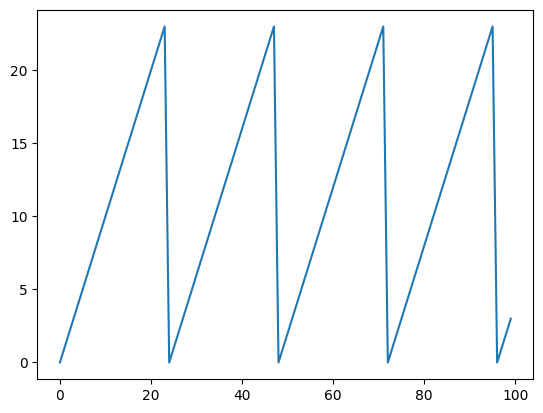

In [24]:
complete_df[:100]["hour"].plot()

In [28]:
def encode_cyclical(df, column, max_val):
    """
    Encodes a cyclical feature using sine and cosine transformations.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the column.
        column (str): The name of the cyclical column to encode.
        max_val (int): The maximum value of the cyclical feature (period).
    
    Returns:
        pd.DataFrame: DataFrame with new sine and cosine columns.
    """
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

In [29]:
# Encode 'hour' (0-23)
complete_df = encode_cyclical(complete_df, 'hour', 24)

# Encode 'day_of_week' (0-6)
complete_df = encode_cyclical(complete_df, 'day_of_week', 7)

# Encode 'month' (1-12)
complete_df = encode_cyclical(complete_df, 'month', 12)

In [ ]:
# Drop original columns
#complete_df.drop(['hour', 'day_of_week', 'month'], axis=1, inplace=True)

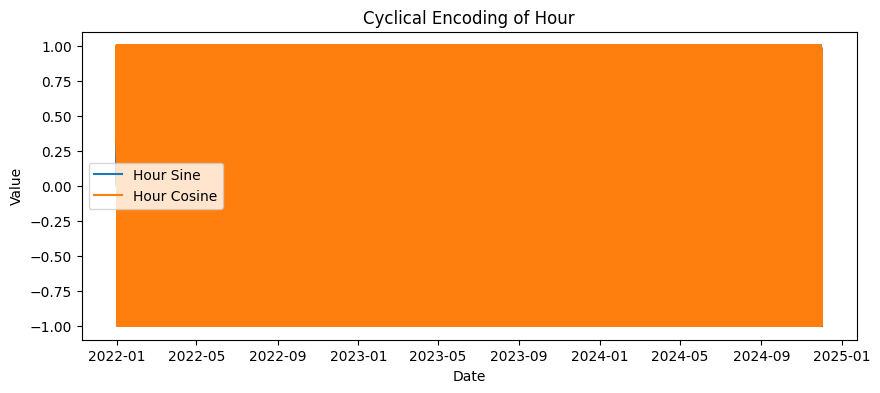

In [30]:
# Plot sine and cosine of 'hour'
plt.figure(figsize=(10, 4))
plt.plot(complete_df['effectivedate'], complete_df['hour_sin'], label='Hour Sine')
plt.plot(complete_df['effectivedate'], complete_df['hour_cos'], label='Hour Cosine')
plt.title('Cyclical Encoding of Hour')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

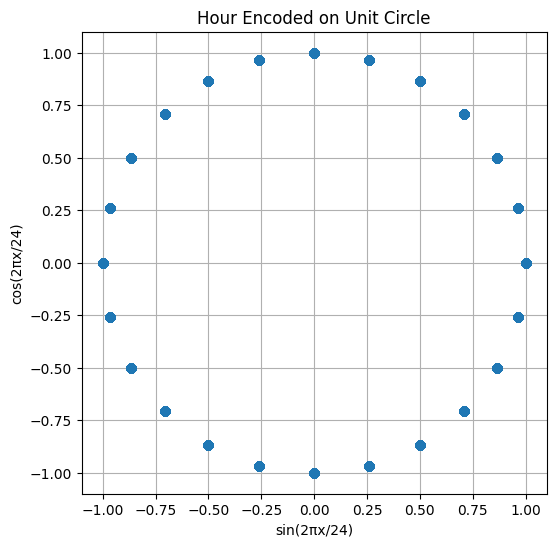

In [31]:
# Create a circular plot for 'hour'
plt.figure(figsize=(6, 6))
plt.plot(complete_df['hour_sin'], complete_df['hour_cos'], marker='o', linestyle='', alpha=0.5)
plt.title('Hour Encoded on Unit Circle')
plt.xlabel('sin(2πx/24)')
plt.ylabel('cos(2πx/24)')
plt.grid(True)
plt.show()

In [32]:
complete_df

,effectivedate,forecast_provider,plant_name,fc0,fc1200,fc40,fc55,fc60,fc75,production,...,month,day,day_of_week,hour,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,2022-01-01 00:00:00,Provider 1,Plant A,5.498515,8.245363,2.456326,2.932484,2.932484,2.371797,11.886,...,1,1,5,0,0.000000,1.000000,-0.974928,-0.222521,0.5,0.866025
1,2022-01-01 01:00:00,Provider 1,Plant A,9.926987,6.013426,5.336242,3.760841,3.760841,2.797678,9.897,...,1,1,5,1,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025
2,2022-01-01 02:00:00,Provider 1,Plant A,6.701120,4.307169,9.771231,7.412186,7.412186,5.529619,7.659,...,1,1,5,2,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025
3,2022-01-01 03:00:00,Provider 1,Plant A,7.487892,3.433257,7.061040,5.776711,5.776711,5.481769,0.332,...,1,1,5,3,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025
4,2022-01-01 04:00:00,Provider 1,Plant A,0.367348,3.000605,3.415112,6.269600,6.269600,6.512737,0.251,...,1,1,5,4,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166868,2024-11-30 19:00:00,Provider 6,Plant N,9.936735,3.636002,5.631102,5.631101,5.631101,5.203560,12.280,...,11,30,5,19,-0.965926,0.258819,-0.974928,-0.222521,-0.5,0.866025
1166869,2024-11-30 20:00:00,Provider 6,Plant N,9.208887,3.967602,7.155135,6.882001,6.882001,6.585664,8.940,...,11,30,5,20,-0.866025,0.500000,-0.974928,-0.222521,-0.5,0.866025
1166870,2024-11-30 21:00:00,Provider 6,Plant N,7.232888,3.838497,6.756964,6.951433,6.951433,6.602408,11.980,...,11,30,5,21,-0.707107,0.707107,-0.974928,-0.222521,-0.5,0.866025
1166871,2024-11-30 22:00:00,Provider 6,Plant N,7.785483,4.630174,7.446291,7.334275,7.334275,7.372441,17.280,...,11,30,5,22,-0.500000,0.866025,-0.974928,-0.222521,-0.5,0.866025


In [22]:
""" # Define the number of lag periods
lag_periods = 24  # e.g., past 24 hours

# Create lag features for 'fc0' and 'production'
for lag in range(1, lag_periods + 1):
    complete_df[f'fc0_lag_{lag}'] = complete_df.groupby(['plant_name', 'forecast_provider'])['fc0'].shift(lag) """